# Plotting GRACE-FO LWE data from a NetCDF

In [3]:
import xarray as xr
from datetime import date
import matplotlib.pyplot as plt
from matplotlib import colors
from pathlib import Path

# Test should run from root
import os

os.chdir("..")

We start by pulling the `TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2` data

In [5]:
from omegaconf import OmegaConf
from metaearth.api import extract_assets
from metaearth.config import ConfigSchema

cfg = OmegaConf.load("config/grace-fo.yml")
cfg_schema = OmegaConf.structured(ConfigSchema)
cfg = OmegaConf.merge(cfg_schema, cfg)

# Constrain the test to only pull one item
for pvdr in cfg.providers:
    for coll in pvdr.collections:
        coll.max_items = 1

success = extract_assets(cfg)
print("Successfully extracted assets." if success else "Asset extraction failed.")

06:48:04 INFO - Extraction details for provider ProviderKey.EARTHDATA with collection TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2: 
id: TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2
assets:
- all
outdir: null
datetime: null
aoi_file: null
max_items: 1

06:48:05 INFO - EarthData Provider returned 1 items for TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2 for datetime 2022-01-01/2022-04-30
06:48:05 INFO - 3 assets did not specify file size, will query size directly with http request (this may take a few moments)
system.query_asset_sizes=False can be used to disable this behavior
100%|██████████| 3/3 [00:04<00:00,  1.65s/it]
06:48:10 INFO - 2 assets have unknown file size
06:48:10 INFO - 

****************************************************************************************************
To Extract:
EarthData Provider: TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2.v02


Collection               | Key                 | Description
-----------------------------------------------------------------------------

Successfully extracted assets.


Let's load our NetCDF file we obtained from MetaEarth

In [6]:
# Find the correct NC file and load it
# We avoid hardcoding the path here in case the API changes down the road

fpath = Path(cfg["default_collection"]["outdir"])
collection_for_nb = "TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2.v02"
nc_files = list((fpath / collection_for_nb).glob("**/*.nc"))

# We know there is only one file pulled, assert
assert (
    len(nc_files) == 1
), f"There were {len(nc_files)} files pulled. `max_items: 1` failed to constrain."

nc_file_fpath = nc_files[0]
ncfile = xr.open_dataset(nc_file_fpath)

We can view the attributes and variables in our loaded NetCDF file

In [7]:
ncfile

<xarray.Dataset>
Dimensions:        (lon: 720, lat: 360, time: 210, bounds: 2)
Coordinates:
  * lon            (lon) float64 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * lat            (lat) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time           (time) datetime64[ns] 2002-04-17T12:00:00 ... 2022-06-16
Dimensions without coordinates: bounds
Data variables:
    lwe_thickness  (time, lat, lon) float64 ...
    uncertainty    (time, lat, lon) float64 ...
    lat_bounds     (lat, bounds) float64 ...
    lon_bounds     (lon, bounds) float64 ...
    time_bounds    (time, bounds) datetime64[ns] ...
Attributes: (12/53)
    Conventions:                   CF-1.6, ACDD-1.3, ISO 8601
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    title:                         JPL GRACE and GRACE-FO MASCON RL06Mv2 CRI
    summary:                       Monthly gravity solutions from GRACE and G...
    keywords:                      Solid Earth, Geodetics/Gravity, Gravity, l...
    ...                            ...
    C_30_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    user_note_1:                   The accelerometer on the GRACE-B spacecraf...
    user_note_2:                   The accelerometer on the GRACE-D spacecraf...
    journal_reference:             Watkins, M. M., D. N. Wiese, D.-N. Yuan, C...
    CRI_filter_journal_reference:  Wiese, D. N., F. W. Landerer, and M. M. Wa...
    date_created:                  2022-08-03T08:08:00Z

Let's select a specific timestamp in our NetCDF and verify that we have selected one single time slice (the time dimension is now a singleton)

In [8]:
ncfile_select = ncfile.sel(time="2022-06-16T00:00:00.000000000")

In [9]:
ncfile_select

<xarray.Dataset>
Dimensions:        (lon: 720, lat: 360, bounds: 2)
Coordinates:
  * lon            (lon) float64 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * lat            (lat) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
    time           datetime64[ns] 2022-06-16
Dimensions without coordinates: bounds
Data variables:
    lwe_thickness  (lat, lon) float64 ...
    uncertainty    (lat, lon) float64 ...
    lat_bounds     (lat, bounds) float64 -90.0 -89.5 -89.5 ... 89.5 89.5 90.0
    lon_bounds     (lon, bounds) float64 0.0 0.5 0.5 1.0 ... 359.5 359.5 360.0
    time_bounds    (bounds) datetime64[ns] 2022-06-01 2022-06-30T23:59:59.913600
Attributes: (12/53)
    Conventions:                   CF-1.6, ACDD-1.3, ISO 8601
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    title:                         JPL GRACE and GRACE-FO MASCON RL06Mv2 CRI
    summary:                       Monthly gravity solutions from GRACE and G...
    keywords:                      Solid Earth, Geodetics/Gravity, Gravity, l...
    ...                            ...
    C_30_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    user_note_1:                   The accelerometer on the GRACE-B spacecraf...
    user_note_2:                   The accelerometer on the GRACE-D spacecraf...
    journal_reference:             Watkins, M. M., D. N. Wiese, D.-N. Yuan, C...
    CRI_filter_journal_reference:  Wiese, D. N., F. W. Landerer, and M. M. Wa...
    date_created:                  2022-08-03T08:08:00Z

We can now plot the LWE data in the NetCDF file.

We begin by defining a new norm for our `seismic` diverging colormap such that the center point is 0. Then, we create a mesh using the `lon`, `lat`, and `lwe_thickness` variables in our NetCDF.

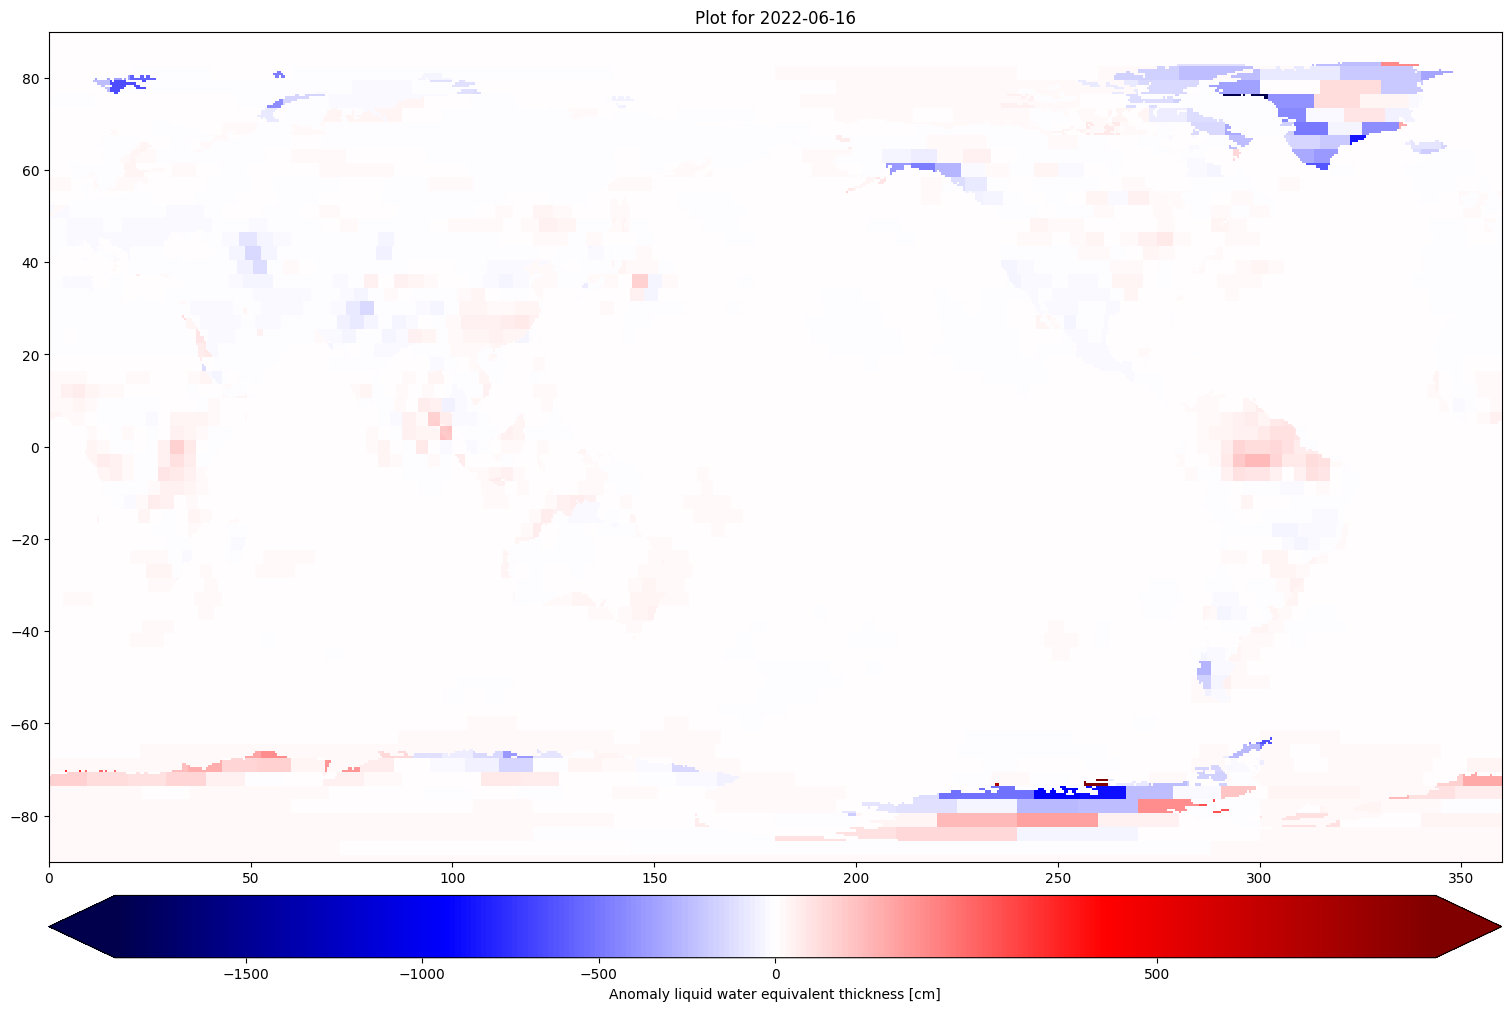

In [10]:
lat = ncfile_select.variables["lat"][:]
lon = ncfile_select.variables["lon"][:]
lwe_thickness = ncfile_select.variables["lwe_thickness"][:]

divnorm = colors.TwoSlopeNorm(
    vmin=lwe_thickness.min(), vcenter=0.0, vmax=lwe_thickness.max()
)

fig, axs = plt.subplots(
    figsize=(15, 10),
    nrows=2,
    ncols=1,
    gridspec_kw={"height_ratios": [20, 1.5]},
    constrained_layout=True,
)
pcm = axs[0].pcolormesh(lon, lat, lwe_thickness, cmap="seismic", norm=divnorm)
axs[0].title.set_text("Plot for 2022-06-16")
cbar = fig.colorbar(pcm, cax=axs[1], extend="both", orientation="horizontal")
cbar.set_label("Anomaly liquid water equivalent thickness [cm]")